In [1]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import regex as re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle

In [3]:
true_df=pd.read_csv('True.csv')
false_df=pd.read_csv('Fake.csv')

In [4]:
true_df.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [5]:
#quality checking
print("checking missing values....")
print(true_df.isnull().sum())
true_df.info()

checking missing values....
title      0
text       0
subject    0
date       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
false_df.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [7]:
false_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
true_df['label']=1
false_df['label']=0

In [9]:
data=pd.concat([true_df,false_df])
data.drop(['text','subject','date'],axis=1,inplace=True)

In [10]:
random_indexes = np.random.randint(0,len(data),len(data))
data = data.iloc[random_indexes].reset_index(drop=True)

In [11]:
#analysis
pd.set_option('display.max_colwidth',500)
rand_=np.random.randint(0,len(data),50)
data.iloc[rand_]

,title,label
2690,'You are fake news!' Trump presides over turbulent news conference,1
37878,Beijing kindergartens get permanent inspectors after abuse scandal: Xinhua,1
39488,U.S. slated to sell $375 million of emergency reserve oil this winter,1
14903,"Trump cyber security team, policy slow to take shape: officials",1
7150,France sold two military ships to United Arab Emirates: Macron,1
37747,Obama commends Northern Ireland leaders on peace progress: White House,1
11818,"Greedy Oil CEO Fires 20 Percent Of Employees, Awards Himself $18 Million",0
5732,U.S. Senate aims to vote later Wednesday on Puerto Rico bill,1
26772,OBAMA RACES TO SET GITMO TERRORISTS FREE…Leaves Servicemen Punished For Making “Heat-of-the-battle decisions that saved lives” In Fort Leavenworth,0
19902,"Honduran president ignores new election calls, opponent warns of 'civil war'",1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [13]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ritra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ritra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritra\AppData\Roaming\nltk_data...


In [14]:
text_cleaning = r"\b0\S*|\b[^A-Za-z0-9\s]+"

def preprocess_filter(text, stem=False):
  text = re.sub(text_cleaning, " ",str(text.lower()).strip())
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        stemmer = SnowballStemmer(language='english')
        token = stemmer.stem(token)
      tokens.append(token)
  return " ".join(tokens)

In [15]:
data['processed_text'] = data['title'].apply(preprocess_filter)
data

,title,label,processed_text
0,"BOOM! Trump Allows Pro-Illegal Alien Heckler To Ask Question, Then Destroys Her With This Response [VIDEO]",0,boom trump allows pro illegal alien heckler ask question destroys response [video
1,WOMAN ARRESTED For Wearing T-Shirt Naming Muslim Extremist Who Fled Country After Failed Jihad Attempt [VIDEO],0,woman arrested wearing shirt naming muslim extremist fled country failed jihad attempt [video
2,Cheerleading Assassination: Are Hollywood and Politicians Going Too Far?,0,cheerleading assassination hollywood politicians going far
3,DEPARTMENT OF JUSTICE Fines Sheriff For Excluding Illegals When Hiring,0,department justice fines sheriff excluding illegals hiring
4,UK PM May says believes Northern Irish accord possible; wants more talks,1,uk pm may says believes northern irish accord possible wants talks
...,...,...,...
44893,Senate Democratic leader urges removal of House intel panel chair,1,senate democratic leader urges removal house intel panel chair
44894,"Obama speaks to Philippines' president-elect, stresses human rights",1,obama speaks philippines president elect stresses human rights
44895,TRUMP POISED TO REVERSE OBAMA’S Politicized “Global Warming” Policies…Plans To Bring Energy Jobs Back To Americans,0,trump poised reverse obama politicized “global warming policies plans bring energy jobs back americans
44896,"Former Canadian PM rebukes Trump on NAFTA, predicts his defeat",1,former canadian pm rebukes trump nafta predicts defeat


C:\Users\ritra\AppData\Local\Temp\ipykernel_684\991934554.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='hls')


<Axes: xlabel='label', ylabel='count'>

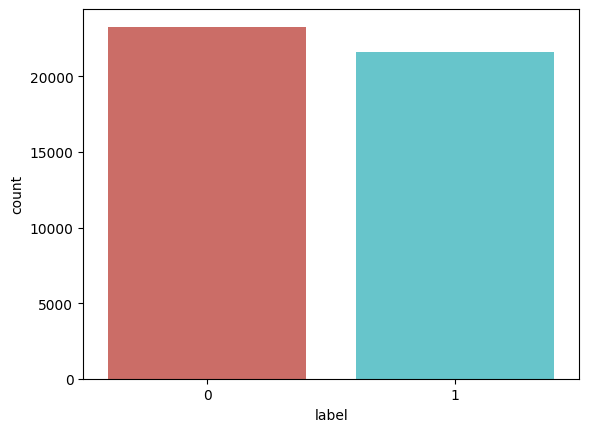

In [16]:
sns.countplot(x='label', data=data, palette='hls')

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(data['processed_text'], data['label'], test_size=0.3, random_state=1)

In [18]:
tfidf_v = TfidfVectorizer()

# Fit and transform the training data
tfidf_X_train = tfidf_v.fit_transform(X_train)

# Transform the test data
tfidf_X_test = tfidf_v.transform(X_test)

# Define the pipeline
logistic_pipe = Pipeline([
    ('tfidf', tfidf_v),  # Use the TfidfVectorizer in the pipeline
    ('logR_Clf', LogisticRegression())
])

# Fit the pipeline on the training data
logistic_pipe.fit(X_train, Y_train)

# Predict on the test data
Y_logR = logistic_pipe.predict(X_test)

# Calculate accuracy
accuracy_logR = sklearn.metrics.accuracy_score(Y_test, Y_logR)
print("Test Accuracy:", accuracy_logR)

Test Accuracy: 0.9551596139569414


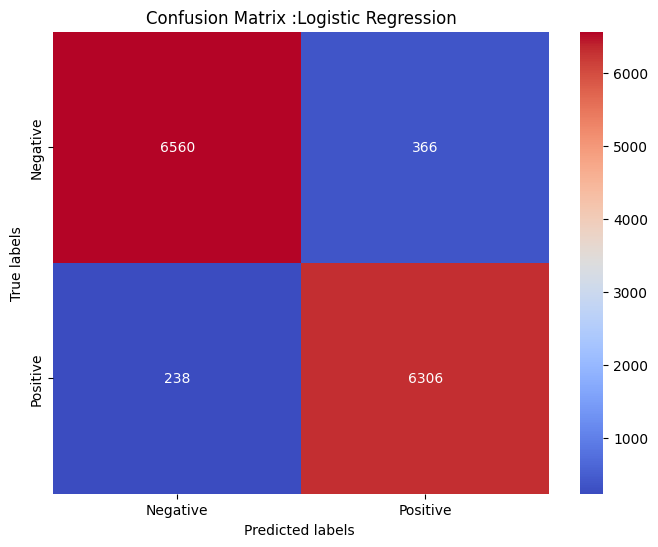

In [19]:
cm_log = confusion_matrix(Y_test, Y_logR)

# Plot confusion matrix
def plot_cm(cm,color_map,model_name=''):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap=color_map, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted labels ')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix '+model_name)
  plt.show()

plot_cm(cm_log,'coolwarm',':Logistic Regression')

In [21]:
from sklearn.svm import SVC
svm_pipeline=Pipeline([('tfidf',tfidf_v),('svm_clf',SVC(kernel='linear',probability=True))])
svm_pipeline.fit(X_train,Y_train)
Y_svm=svm_pipeline.predict(X_test)
accuracy_svm=sklearn.metrics.accuracy_score(Y_test,Y_svm)
print("Test Accuracy:",accuracy_svm)

Test Accuracy: 0.9632516703786191


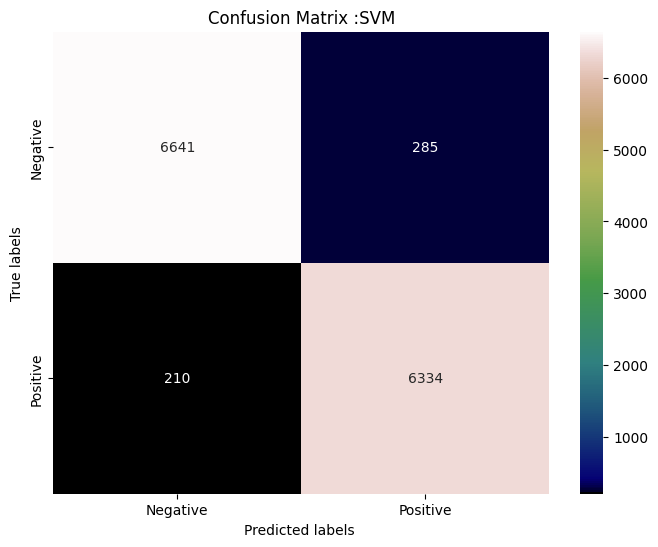

In [22]:
cm_svm = confusion_matrix(Y_test, Y_svm)
plot_cm(cm_svm,'gist_earth',':SVM')

In [23]:
sgd_pipeline=Pipeline([('tfidf',tfidf_v),('sgdc_clf',SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3,max_iter=1000))])
sgd_pipeline.fit(X_train,Y_train)
Y_sgd=sgd_pipeline.predict(X_test)
accuracy_sgd=sklearn.metrics.accuracy_score(Y_test,Y_sgd)
print("Test Accuracy:",accuracy_sgd)

Test Accuracy: 0.9277654046028211


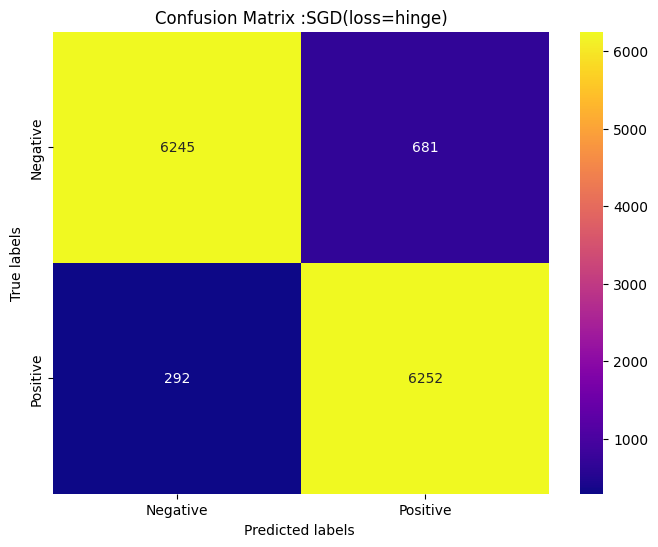

In [24]:
cm_sgd = confusion_matrix(Y_test, Y_sgd)
plot_cm(cm_sgd,'plasma',':SGD(loss=hinge)')

In [26]:
sgd_log_pipeline=Pipeline([('tfidf',tfidf_v),('sgdc_clf',SGDClassifier(loss='log_loss',penalty='l2',alpha=1e-3,max_iter=1000))])
sgd_log_pipeline.fit(X_train,Y_train)
Y_sgd_log=sgd_log_pipeline.predict(X_test)
accuracy_sgd_log=sklearn.metrics.accuracy_score(Y_test,Y_sgd_log)
print("Test Accuracy:",accuracy_sgd_log)

Test Accuracy: 0.9178173719376392


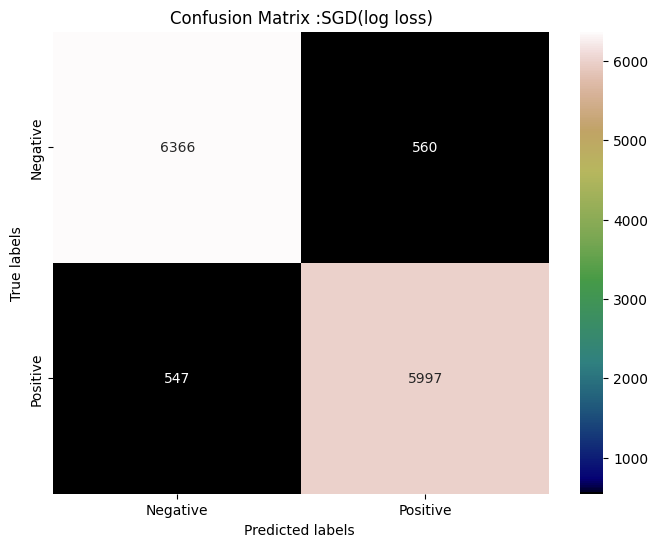

In [27]:
cm_sgd_log = confusion_matrix(Y_test, Y_sgd_log)
plot_cm(cm_sgd_log,'gist_earth',':SGD(log loss)')

In [28]:
sgd_sl_pipeline=Pipeline([('tfidf',tfidf_v),('sgdc_clf',SGDClassifier(loss='squared_error',penalty='l2',alpha=1e-3,max_iter=1000))])
sgd_sl_pipeline.fit(X_train,Y_train)
Y_sl_sgd=sgd_sl_pipeline.predict(X_test)
accuracy_sgd_sl=sklearn.metrics.accuracy_score(Y_test,Y_sl_sgd)
print("Test Accuracy:",accuracy_sgd_sl)

Test Accuracy: 0.9354862657757981


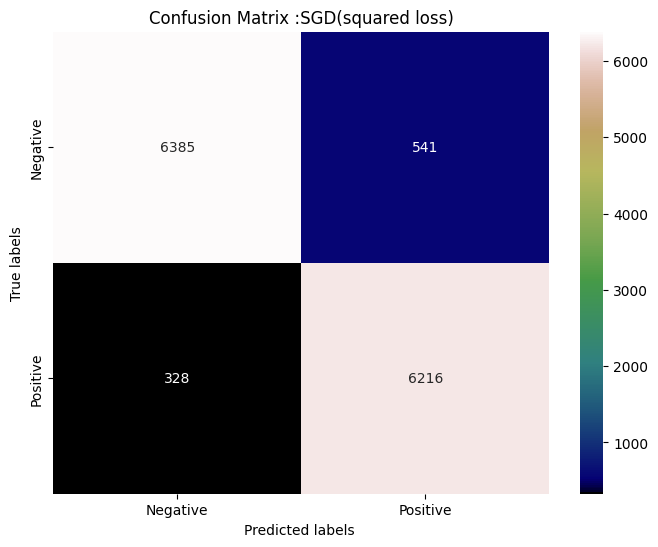

In [29]:
cm_sgd_sl = confusion_matrix(Y_test, Y_sl_sgd)
plot_cm(cm_sgd_sl,'gist_earth',':SGD(squared loss)')

In [30]:
sgd_3_pipeline=Pipeline([('tfidf',tfidf_v),('sgdc_clf',SGDClassifier(loss='perceptron',penalty='l2',alpha=1e-4,max_iter=1000))])
sgd_3_pipeline.fit(X_train,Y_train)
Y_3_sgd=sgd_3_pipeline.predict(X_test)
accuracy_sgd_3=sklearn.metrics.accuracy_score(Y_test,Y_3_sgd)
print("Test Accuracy:",accuracy_sgd_3)

Test Accuracy: 0.9636971046770602


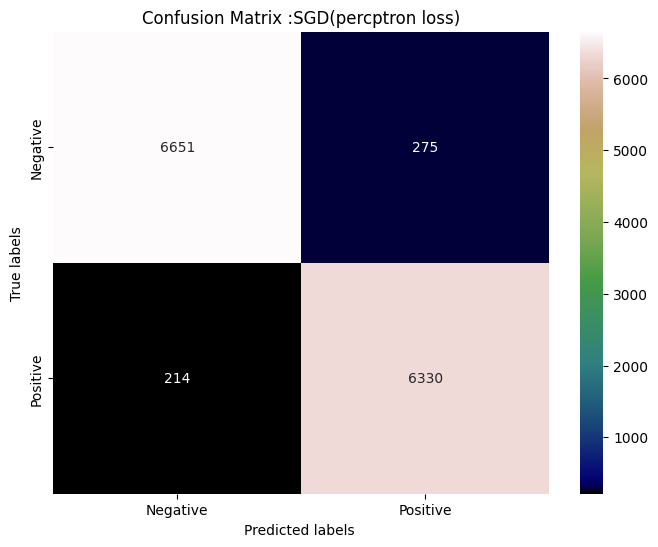

In [31]:
cm_sgd3 = confusion_matrix(Y_test, Y_3_sgd)
plot_cm(cm_sgd3,'gist_earth',':SGD(percptron loss)')

In [32]:
random_forest=Pipeline([('tfidf',tfidf_v),('rf_clf',RandomForestClassifier(n_estimators=200,n_jobs=3))])
random_forest.fit(X_train,Y_train)
Y_rf=random_forest.predict(X_test)
accuracy_rf=sklearn.metrics.accuracy_score(Y_test,Y_rf)
print("Test accuracy:",accuracy_rf)

Test accuracy: 0.96815144766147


In [33]:
probabilities = random_forest.predict_proba(X_test)

# Probability of the positive class (label 1)
prob_of_true = probabilities[:, 1]

print("Probabilities of being true:", prob_of_true)

Probabilities of being true: [0.01  0.945 0.035 ... 0.005 0.805 1.   ]


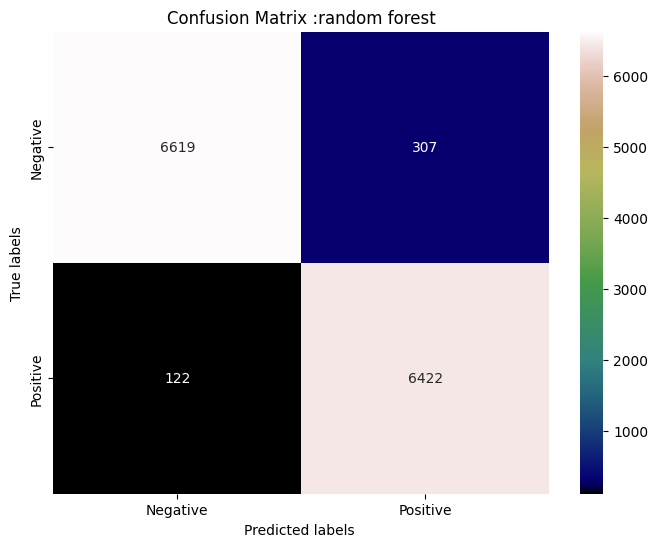

In [34]:
cm_rf = confusion_matrix(Y_test, Y_rf)
plot_cm(cm_rf,'gist_earth',':random forest')

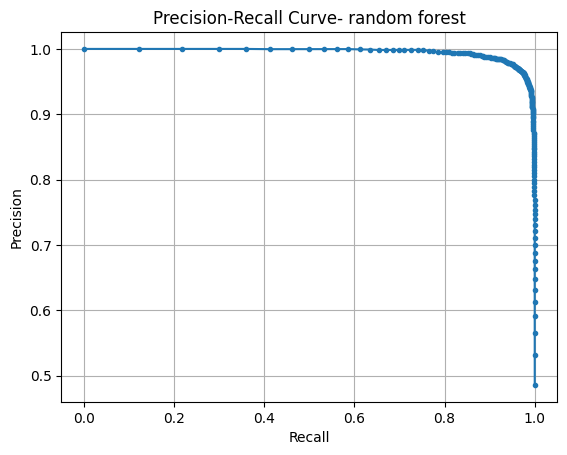

In [35]:
y_scores = random_forest.predict_proba(X_test)[:,1]

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(Y_test, y_scores)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve- random forest')
plt.grid(True)
plt.show()


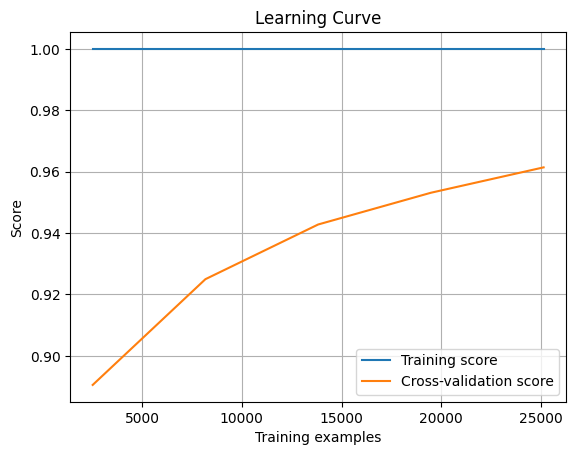

In [36]:
#among all models random forest is best
train_sizes, train_scores, test_scores = learning_curve(random_forest, X_train, Y_train, cv=5)
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
with open('random_forest_pipeline.pkl', 'wb') as f:
    pickle.dump(random_forest, f)